# Under- and overfitting, model selection

## Preliminaries

In the first set of exercises you had to implement the training and evaluation of the linear regression and $k$-NN methods from scratch in order to practice your `numpy` skills. From this set of exercises onward, you can use the implementations provided in `scikit-learn` or other higher-level libraries. We start this set of exercises by demonstrating some of the features of `scikit-learn`.

For example, implementation of linear regression model fitting with an analytical solution for the parameters is provided by the class `sklearn.linear_model.LinearRegression`. You can train a linear regression model in the following way:

In [24]:
import numpy as np
from sklearn import datasets, linear_model

# load the diabetes dataset
diabetes = datasets.load_diabetes()

# use only one feature
X = diabetes.data[:, np.newaxis, 2]
y = diabetes.target

# split the data into training/testing sets
X_train = X[:-20]
X_test = X[-20:]

# split the targets into training/testing sets
y_train = y[:-20]
y_test = y[-20:]

# create linear regression object
model = linear_model.LinearRegression()

# train the model using the training dataset
model.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Let's visualize the training dataset and the learned regression model.

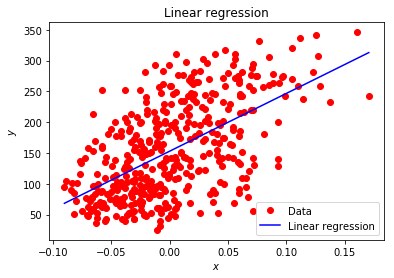

In [25]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(X_train, y_train, 'r.', markersize=12)
X_edge = np.array([np.min(X_train, 0), np.max(X_train, 0)])
plt.plot(X_edge, model.predict(X_edge), 'b-')
plt.legend(('Data', 'Linear regression'), loc='lower right')
plt.title('Linear regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()

Once trained, the model can be used to make predictions on the test data:

In [26]:
# Make predictions using the testing dataset
prediction = model.predict(X_test)

The next step (not shown here) is to evaluate the performance of the trained model.

Note that the `scikit-learn` interface works by first initializing an object from the class that implements the machine learning model (linear regression in this case) and then fitting the initialized model using the data in the training set. Finally, the trained (fitted) model can be used to make predictions on unseen data. In fact, all models implemented in this library follow the same *initialize-fit-predict* programming interface. For example, a $k$-NN classifier can be trained in the following way:

In [27]:
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors

breast_cancer = datasets.load_breast_cancer()

X = breast_cancer.data
y = breast_cancer.target

# make use of the train_test_split() utility function instead
# of manually dividing the data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

# initialize a 3-NN classifier
model = neighbors.KNeighborsClassifier(n_neighbors=3)

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)

Note that the features in the breast cancer dataset have different scales (some have on average very small absolute values, and some very large), which means that the distance metric used by $k$-NN will me dominated by the features with large values. You can use any of the number of feature transformation methods implemented in `scikit-learn` to scale the features. For example, you can use the `sklearn.preprocessing.StandardScaler` method to transform all features to a have a zero mean and unit variance:

In [28]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)

The scaler has its own parameters which are the means and standard deviations of the features estimated from the training set. If you train a model with the scaled features, you will have to remember to also apply the scaling transformation every time you make a prediction on new unseen and unscaled data. This is somewhat prone to error. One option for making the code more robust is to create a processing pipeline that includes the scaling and $k$-NN models in a sequence:

In [29]:
from sklearn.pipeline import Pipeline

knn = neighbors.KNeighborsClassifier(n_neighbors=3)

model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

# train the model using the training dataset
model.fit(X_train, y_train)

# make predictions using the testing dataset
prediction = model.predict(X_test)


If you are curious, more information about the design of the `scikit-learn` application programming interface (API) can be found [in this paper](https://arxiv.org/pdf/1309.0238.pdf). 

## Exercises

### Bias-variance decomposition

Show that the mean squared error of the estimate of a parameter can be decomposed into an expression that includes both the bias and variance (Eq. 5.53-5.54 in "Deep learning" by Goodfellow et al.). 

MSE($\hat{\theta}$) = E[($\hat{\theta}$-$\theta$)^2] 
= E[($\hat{\theta}$ - E[$\hat{\theta}$] + E[$\hat{\theta}$] - $\theta$)^2] 
= E[($\hat{\theta}$ - E[$\hat{\theta}$])^2 + 2*($\hat{\theta}$ - E[$\hat{\theta}$])*(E[$\hat{\theta}$] - $\theta$) + (E[$\hat{\theta}$] - $\theta$)^2] 
= E[($\hat{\theta}$ - E[$\hat{\theta}$])^2] + E[2*($\hat{\theta}$ - E[$\hat{\theta}$])*(E[$\hat{\theta}$] - $\theta$)] +E[(E[$\hat{\theta}$] - $\theta$)^2] 
= Var($\hat{\theta}$) + 2*(E[$\hat{\theta}$] - $\theta$)*E[$\hat{\theta}$ - E[$\hat{\theta}$]] + (E[$\hat{\theta}$] - $\theta$)^2 
= Var($\hat{\theta}$) + 2*(E[$\hat{\theta}$] - $\theta$)*(E[$\hat{\theta}$] - E[$\hat{\theta}$]) + (E[$\hat{\theta}$] - $\theta$)^2 
= Var($\hat{\theta}$) + (E[$\hat{\theta}$] - $\theta$)^2 
= Var($\hat{\theta}$) + bias($\hat{\theta}$)^2
<br>
The above method takes two observations into account: E[$\hat{\theta}$] = constant, since its the expected value of a scalar. This also results that E[$\hat{\theta}$] - $\theta$ is constant. This implies that the expected values of these complete expressions is equal to the value itself, since these are all scalars. The additional expression E[], for the complete expressions above, can hence be omitted. 

### Polynomial regression

For this exercise we will be using generated data to better show the effects of the different polynomial orders.
The data is created using the make_polynomial_regression function.

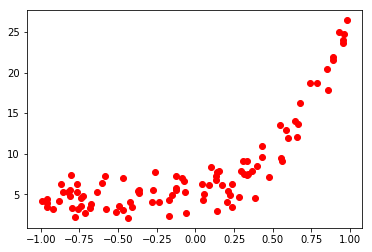

In [30]:
%matplotlib inline

def generate_dataset(n=100, degree=1, noise=1, factors=None):
    # Generates a dataset by adding random noise to a randomly
    # generated polynomial function.
    
    x = np.random.uniform(low=-1, high=1, size=n)
    
    factors = np.random.uniform(0, 10, degree+1)
    
    y = np.zeros(x.shape)
    
    for idx in range(degree+1):
        y += factors[idx] * (x ** idx)

    # add noise
    y += np.random.normal(-noise, noise, n)
    
    return x, y

# load generated data
np.random.seed(0)

X, y = generate_dataset(n=100, degree=4, noise=1.5)

plt.plot(X, y, 'r.', markersize=12)

Implement polynomial regression using the `sklearn.preprocessing.PolynomialFeatures` transformation. Using the `sklearn.grid_search.GridSearchCV` class, perform a grid search of the polynomial order hyperparameter space with cross-validation and report the performance on an independent test set.

10.137500458983954


ValueError: Expected 2D array, got 1D array instead:
array=[-0.97714508 -0.87499751 -0.77284994 -0.67070237 -0.5685548  -0.46640722
 -0.36425965 -0.26211208 -0.15996451 -0.05781694  0.04433063  0.14647821
  0.24862578  0.35077335  0.45292092  0.55506849  0.65721606  0.75936364
  0.86151121  0.96365878].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

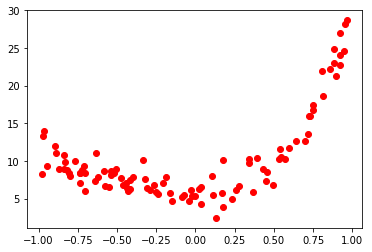

In [31]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn import linear_model
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
#create the model pipeline
polyFeats = PolynomialFeatures(degree=2)
linearModel = linear_model.LinearRegression()

model = Pipeline([
                 ("polynomialFeatures", polyFeats),
                 ("linearModel", linearModel)
                ])

#perform the grid search to tune the hyper-parameters of the model
#print(model.get_params())
model = GridSearchCV(model, {'polynomialFeatures__degree': np.arange(10)})

#Reshape into a 2d array and fit the model
X = np.reshape(X, (-1,1))
model.fit(X,y)


#generate an independent test set
X_test, y_test = generate_dataset(n=100, degree=4, noise=1.5)
X_test = np.reshape(X_test, (-1,1))

#Evaluate Model Performance
print(mean_squared_error(y_test,model.predict(X_test)))

#Plot the model to see the pretty lines
%matplotlib inline

fig = plt.figure()
plt.plot(X_test, y_test, 'r.', markersize=12)
X_wanted = np.linspace(np.min(X_test, 0), np.max(X_test, 0), 20)
plt.plot(X_wanted, model.predict(X_wanted), 'b-')
plt.legend(('Data', 'Polynomial regression'), loc='lower right')
plt.title('Polynomial regression')
plt.xlabel('$x$')
plt.ylabel('$y$')
plt.show()



Plot a learning curve that show the validation accuracy as a function of the polynomial order. 

<p><font color='#770a0a'>Which models have a high bias, and which models have high variance? Motivate your answer.</font><p>
    
Repeat this experiment, this time using the diabetes dataset instead of the generated data.

### ROC curve analysis
A common method to evaluate binary classifiers is the receiver operating characteristic (ROC) curve. Similar to the week one practicals, implement a $k$-NN classifier on the breast cancer dataset, however, his time use the $k$-NN pipeline from the preliminary. Train the model for different values of $k$ and evaluate their respective performance with an ROC curve, use the `sklearn.metrics.roc_curve` function.

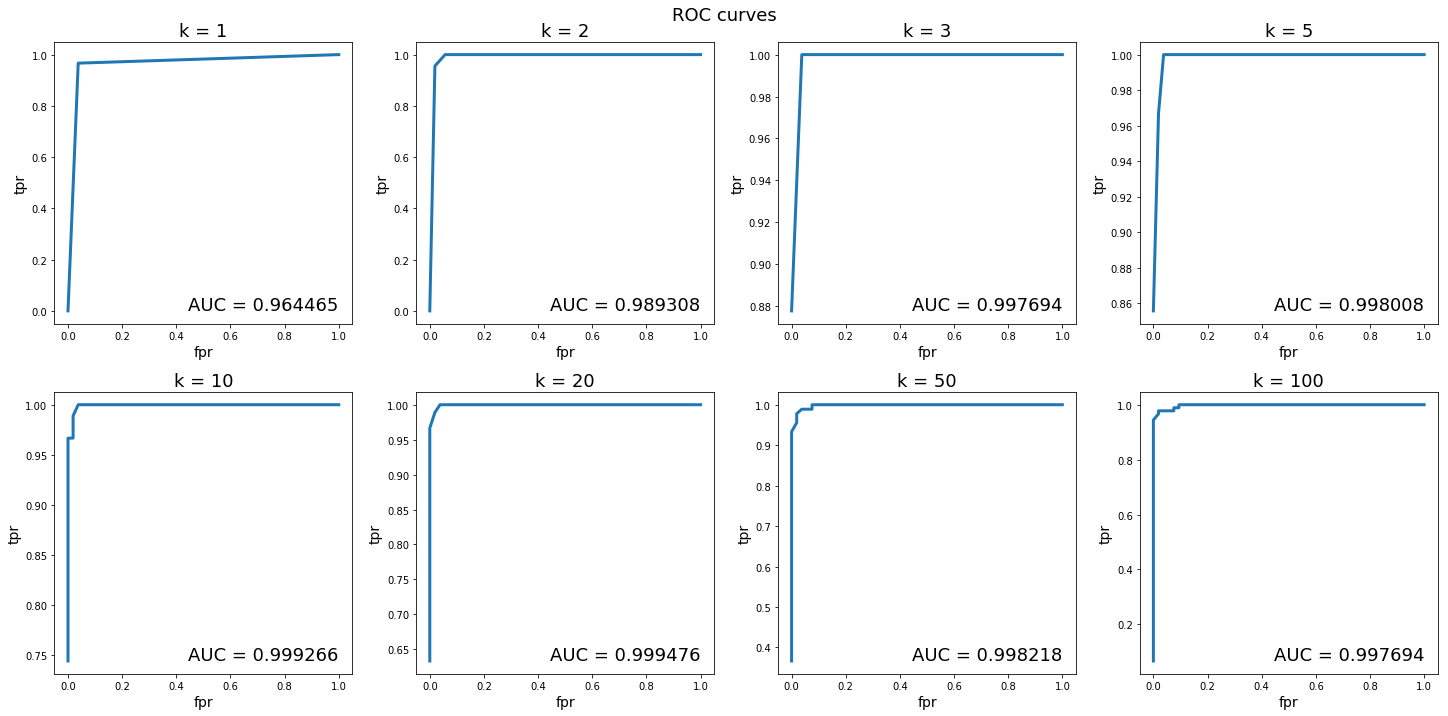

In [48]:
from sklearn.pipeline import Pipeline
from sklearn.metrics import roc_curve,auc,roc_auc_score
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import datasets, neighbors
%matplotlib inline
import matplotlib.pyplot as plt

#Load data
breast_cancer = load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target

#Set values of k tested
k_range = [1,2,3,5,10,20,50,100]

#Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=40)

scaler = StandardScaler()

#Create figures
fig, axs = plt.subplots(2,4, constrained_layout=True, figsize=[20, 10])
fig.suptitle('ROC curves',fontsize=18)

for k_idx,k in enumerate(k_range):
    
    #Specify the model
    knn = neighbors.KNeighborsClassifier(n_neighbors = k)
    
    model = Pipeline([
                 ("scaler", scaler),
                 ("knn", knn)
                ])

    #Train the model using the training dataset
    model.fit(X_train, y_train)

    #Predict probability scores on the test data
    y_score = model.predict_proba(X_test)[:,1]
    
    #Calculate the false positive and true positive rate
    fpr, tpr, thresholds = roc_curve(y_test, y_score)
    
    #Calculate the Area Under the Curve
    auc_score = auc(fpr,tpr)
    
    #Plot the ROC curve
    axs.flat[k_idx].plot(fpr,tpr,lw=3)
    axs.flat[k_idx].set_xlabel('fpr',fontsize=14)
    axs.flat[k_idx].set_ylabel('tpr',fontsize=14)
    axs.flat[k_idx].set_title('k = {}'.format(k),fontsize=18)
    axs.flat[k_idx].text(0.45,0.05,'AUC = {:f}'.format(auc_score),transform=axs.flat[k_idx].transAxes,fontsize=18)



Initially, the ROC curves (and their respective AUC scores) indicate that increasing the value of k generally improves the performance of the algorithm. Judging by the area under the curve, it appears that k = 20 results in the best model. Further reducing the complexity leads to lower performance.


### $F_1$ score and Dice similarity coefficient

The Dice similarity coefficient is a very popular evaluation measure for image segmentation applications. Assuming that $A$ is the ground truth segmentation of an object represented as a binary image, and $B$ is the binary output of an image segmentation method, the Dice similarity coefficient is computed as:

$\text{Dice}(A,B) = \frac{2|A\cap B|}{|A| + |B|}$

where $|\cdot|$ represents the cardinality of the objects (e.g. $|A|$ is the number of non-zero pixels in the ground truth segmentation).

For example, the Dice similarity can be computed in the following way:

In [ ]:
# generate some test objecys
A = np.zeros((32, 32))
A[10:-10, 10:-10] = 1
B = np.zeros((32, 32))
B[5:-15, 5:-15] = 1

dice = 2*np.sum(A*B)/(np.sum(A)+np.sum(B))

# display the results
plt.plot()
plt.imshow(A)
plt.imshow(B, alpha=0.7)

print(dice)

<p><font color='#770a0a'>Show that the $F_1$ score, which is the harmonic mean of precision and recall, is equivalent to the Dice similarity coefficient</font><p>